# Importação de bibliotecas essenciais

In [18]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

# Configuração de estilo de gráficos
sns.set(style="whitegrid")

# Carregameto e Pré-processamento do Conjunto de Dados

In [19]:
data_path = './'
classes = [
    "Cardboard",
    "Food Organics",
    "Glass",
    "Metal",
    "Miscellaneous Trash",
    "Paper",
    "Plastic",
    "Textile Trash",
    "Vegetation"
]

# Função para carregar imagens
def load_images_and_labels(data_path, classes, img_size=(128, 128)):
    images, labels = [], []
    for label in classes:
        class_path = os.path.join(data_path, label)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                img_path = os.path.join(class_path, img_file)
                try:
                    img = load_img(img_path, target_size=img_size)
                    img_array = img_to_array(img) / 255.0  # Normalização
                    images.append(img_array)
                    labels.append(label)
                except Exception as e:
                    print(f"Erro ao carregar imagem {img_path}: {e}")
    return np.array(images), np.array(labels)

# Carregar imagens e rótulos
img_size = (128, 128)
X, y = load_images_and_labels(data_path, classes, img_size)

# Codificar rótulos
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)  # Para CNN

# Dividir os dados
X_train, X_temp, y_train, y_temp = train_test_split(X, y_categorical, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Modelo 1: Rede Neural Convolucional Simples

In [20]:
def create_simple_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Treinamento CNN
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]
cnn_model = create_simple_cnn(input_shape, num_classes)
history_cnn = cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# Avaliação CNN
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(X_test, y_test)
print(f"Teste CNN - Perda: {cnn_test_loss}, Acurácia: {cnn_test_acc}")



y_pred = cnn_model.predict(X_test)

# Converter previsões e rótulos verdadeiros de one-hot encoding para rótulos de classe
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calcular o F1-score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"F1-score : {f1}")

c:\USERS\NATHA\ONEDRIVE\DESKTOP\UEL\ML\PROJETO\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 27s 245ms/step - accuracy: 0.2155 - loss: 2.4321 - val_accuracy: 0.2791 - val_loss: 1.9825
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 39s 224ms/step - accuracy: 0.3123 - loss: 1.8836 - val_accuracy: 0.4081 - val_loss: 1.7219
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 24s 228ms/step - accuracy: 0.3863 - loss: 1.6844 - val_accuracy: 0.3913 - val_loss: 1.5634
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 0.4249 - loss: 1.5285 - val_accuracy: 0.4250 - val_loss: 1.5249
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 24s 229ms/step - accuracy: 0.4643 - loss: 1.4292 - val_accuracy: 0.4909 - val_loss: 1.4214
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 25s 244ms/step - accuracy: 0.5084 - loss: 1.3049 - val_accuracy: 0.4909 - val_loss: 1.4162
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 25s 235ms/step - accuracy: 0.5510 - loss: 1.1969 - val_accuracy: 0.5778 - val_loss: 1.2326
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 24s 234ms/step - accuracy: 0.6351 - loss: 1

# Modelo 2: K-Nearest Neighbors (KNN)

In [21]:
# Transformar dados para 1D
X_flat = X.reshape(X.shape[0], -1)
X_train_knn, X_temp_knn, y_train_knn, y_temp_knn = train_test_split(X_flat, y_encoded, test_size=0.3, random_state=42)
X_val_knn, X_test_knn, y_val_knn, y_test_knn = train_test_split(X_temp_knn, y_temp_knn, test_size=0.5, random_state=42)

# Treinamento do KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_knn, y_train_knn)

# Avaliação do KNN
knn_y_pred = knn_model.predict(X_test_knn)
knn_accuracy = np.mean(knn_y_pred == y_test_knn)
print(f"Acurácia do KNN: {knn_accuracy}")
print(classification_report(y_test_knn, knn_y_pred, target_names=label_encoder.classes_))

Acurácia do KNN: 0.3450210378681627
                     precision    recall  f1-score   support

          Cardboard       0.32      0.27      0.29        78
      Food Organics       0.62      0.09      0.16        56
              Glass       0.20      0.80      0.33        56
              Metal       0.48      0.46      0.47       118
Miscellaneous Trash       0.31      0.28      0.29        72
              Paper       0.67      0.38      0.49        81
            Plastic       0.36      0.50      0.42       130
      Textile Trash       0.38      0.11      0.17        46
         Vegetation       0.00      0.00      0.00        76

           accuracy                           0.35       713
          macro avg       0.37      0.32      0.29       713
       weighted avg       0.38      0.35      0.32       713



c:\USERS\NATHA\ONEDRIVE\DESKTOP\UEL\ML\PROJETO\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\USERS\NATHA\ONEDRIVE\DESKTOP\UEL\ML\PROJETO\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\USERS\NATHA\ONEDRIVE\DESKTOP\UEL\ML\PROJETO\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

# Modelo 3: Random Forest

In [22]:
# Treinamento do Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_knn, y_train_knn)

# Avaliação do Random Forest
rf_y_pred = rf_model.predict(X_test_knn)
rf_accuracy = np.mean(rf_y_pred == y_test_knn)
print(f"Acurácia do Random Forest: {rf_accuracy}")
print(classification_report(y_test_knn, rf_y_pred, target_names=label_encoder.classes_))

Acurácia do Random Forest: 0.6072931276297335
                     precision    recall  f1-score   support

          Cardboard       0.78      0.64      0.70        78
      Food Organics       0.61      0.30      0.40        56
              Glass       0.72      0.59      0.65        56
              Metal       0.55      0.71      0.62       118
Miscellaneous Trash       0.43      0.32      0.37        72
              Paper       0.71      0.63      0.67        81
            Plastic       0.60      0.79      0.68       130
      Textile Trash       0.56      0.22      0.31        46
         Vegetation       0.58      0.82      0.68        76

           accuracy                           0.61       713
          macro avg       0.61      0.56      0.56       713
       weighted avg       0.61      0.61      0.59       713



# Análise Comparativa dos Resultados

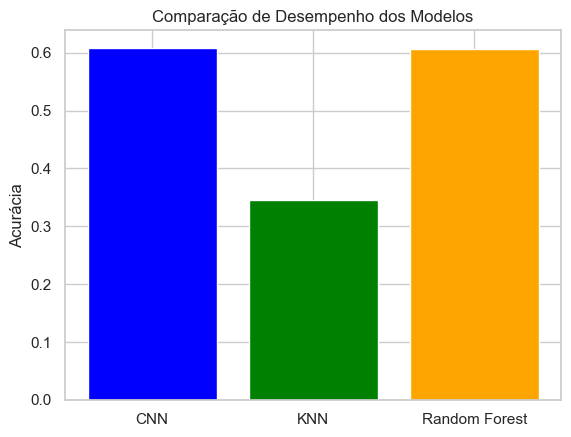

In [23]:
methods = ['CNN', 'KNN', 'Random Forest']
accuracies = [cnn_test_acc, knn_accuracy, rf_accuracy]

plt.bar(methods, accuracies, color=['blue', 'green', 'orange'])
plt.ylabel('Acurácia')
plt.title('Comparação de Desempenho dos Modelos')
plt.show()

# Salvando Resultados e Modelos

In [24]:
cnn_model.save('cnn_realwaste_model.keras')